In [1]:
import pandas as pd
import numpy as np
import torch
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer
)
from torch.utils.data import Dataset

# Configuration
MODEL_NAME = "monologg/biobert_v1.1_pubmed"
MAX_LENGTH = 128
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

2025-12-19 13:55:24.025423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766152524.225216      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766152524.280132      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766152524.723724      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766152524.723772      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766152524.723775      55 computation_placer.cc:177] computation placer alr

In [2]:
# Load Data
try:
    df = pd.read_csv('/kaggle/input/symptom2disease/Symptom2Disease.csv')
except FileNotFoundError:
    df = pd.read_csv('Symptom2Disease.csv')

if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Encode Labels
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])
NUM_LABELS = len(le.classes_)

# Split Data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(),
    df['label_encoded'].tolist(),
    test_size=0.15,
    random_state=RANDOM_SEED,
    stratify=df['label_encoded']
)

print(f"Data loaded. Found {NUM_LABELS} unique diseases.")

Data loaded. Found 24 unique diseases.


/tmp/ipykernel_55/274521884.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df['label'], order = df['label'].value_counts().index, palette='viridis')


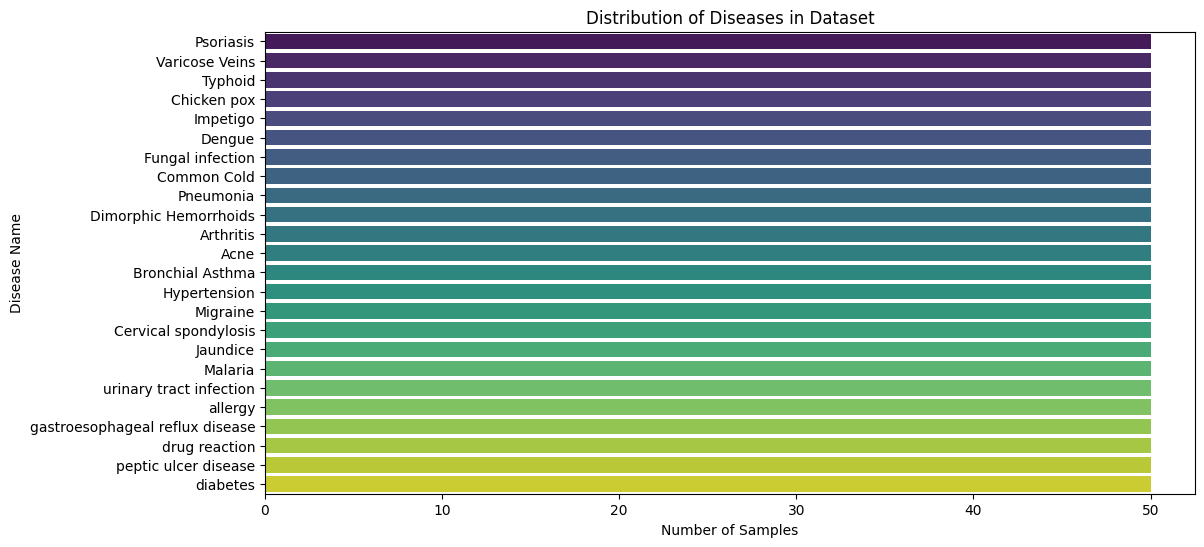

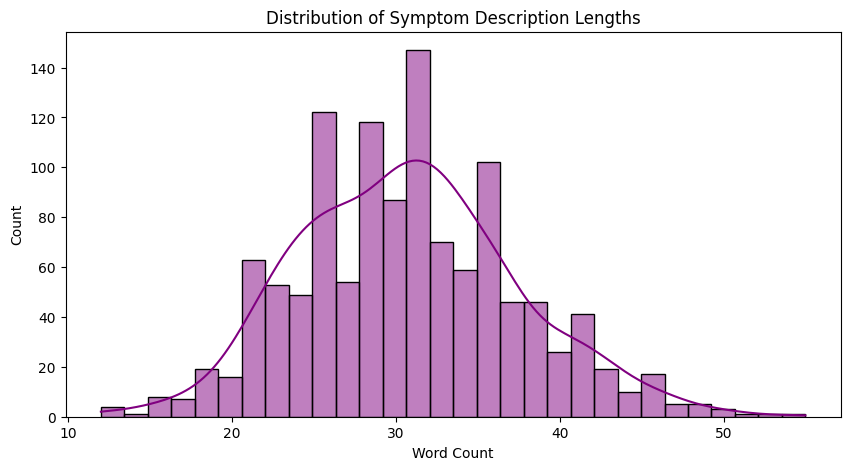

Average word count: 30.73
Max word count: 55


In [3]:
# --- EDA: Visualize the Data ---
plt.figure(figsize=(12, 6))

# 1. Check Class Balance
sns.countplot(y=df['label'], order = df['label'].value_counts().index, palette='viridis')
plt.title('Distribution of Diseases in Dataset')
plt.xlabel('Number of Samples')
plt.ylabel('Disease Name')
plt.show()

# 2. Check Text Lengths (Tokens)
# This helps confirm why we chose MAX_LENGTH=128
df['text_length'] = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 5))
sns.histplot(df['text_length'], bins=30, kde=True, color='purple')
plt.title('Distribution of Symptom Description Lengths')
plt.xlabel('Word Count')
plt.show()

print(f"Average word count: {df['text_length'].mean():.2f}")
print(f"Max word count: {df['text_length'].max()}")

In [4]:
# Tokenizer & Dataset Class
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class DiseaseDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

train_dataset = DiseaseDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
test_dataset = DiseaseDataset(test_texts, test_labels, tokenizer, MAX_LENGTH)

tokenizer_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [5]:
# Model Initialization
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=NUM_LABELS
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/biobert_v1.1_pubmed and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# The Training Loop
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

training_args = TrainingArguments(
    output_dir='./results',
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=WEIGHT_DECAY,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='./logs',
    logging_steps=50,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/tmp/ipykernel_55/1841827537.py:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,2.959298,0.205556,0.133732,0.127766,0.205556
2,3.014700,2.516822,0.477778,0.433238,0.527566,0.477778
3,3.014700,1.992907,0.688889,0.674234,0.818640,0.688889
4,2.333000,1.642313,0.788889,0.769430,0.852377,0.788889
5,1.688500,1.356849,0.850000,0.840272,0.875995,0.850000
6,1.688500,1.156447,0.894444,0.889048,0.907647,0.894444
7,1.256100,1.002492,0.916667,0.913487,0.926675,0.916667
8,0.992900,0.884824,0.944444,0.944405,0.954531,0.944444
9,0.992900,0.825627,0.944444,0.944081,0.949808,0.944444
10,0.828400,0.809978,0.944444,0.944081,0.949808,0.944444


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input

TrainOutput(global_step=320, training_loss=1.6293334782123565, metrics={'train_runtime': 169.8731, 'train_samples_per_second': 60.045, 'train_steps_per_second': 1.884, 'total_flos': 671065720012800.0, 'train_loss': 1.6293334782123565, 'epoch': 10.0})

/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Final Test Metrics: {'eval_loss': 0.884824275970459, 'eval_accuracy': 0.9444444444444444, 'eval_f1': 0.9444049314882648, 'eval_precision': 0.9545314253647588, 'eval_recall': 0.9444444444444444, 'eval_runtime': 1.0369, 'eval_samples_per_second': 173.59, 'eval_steps_per_second': 5.786, 'epoch': 10.0}


/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


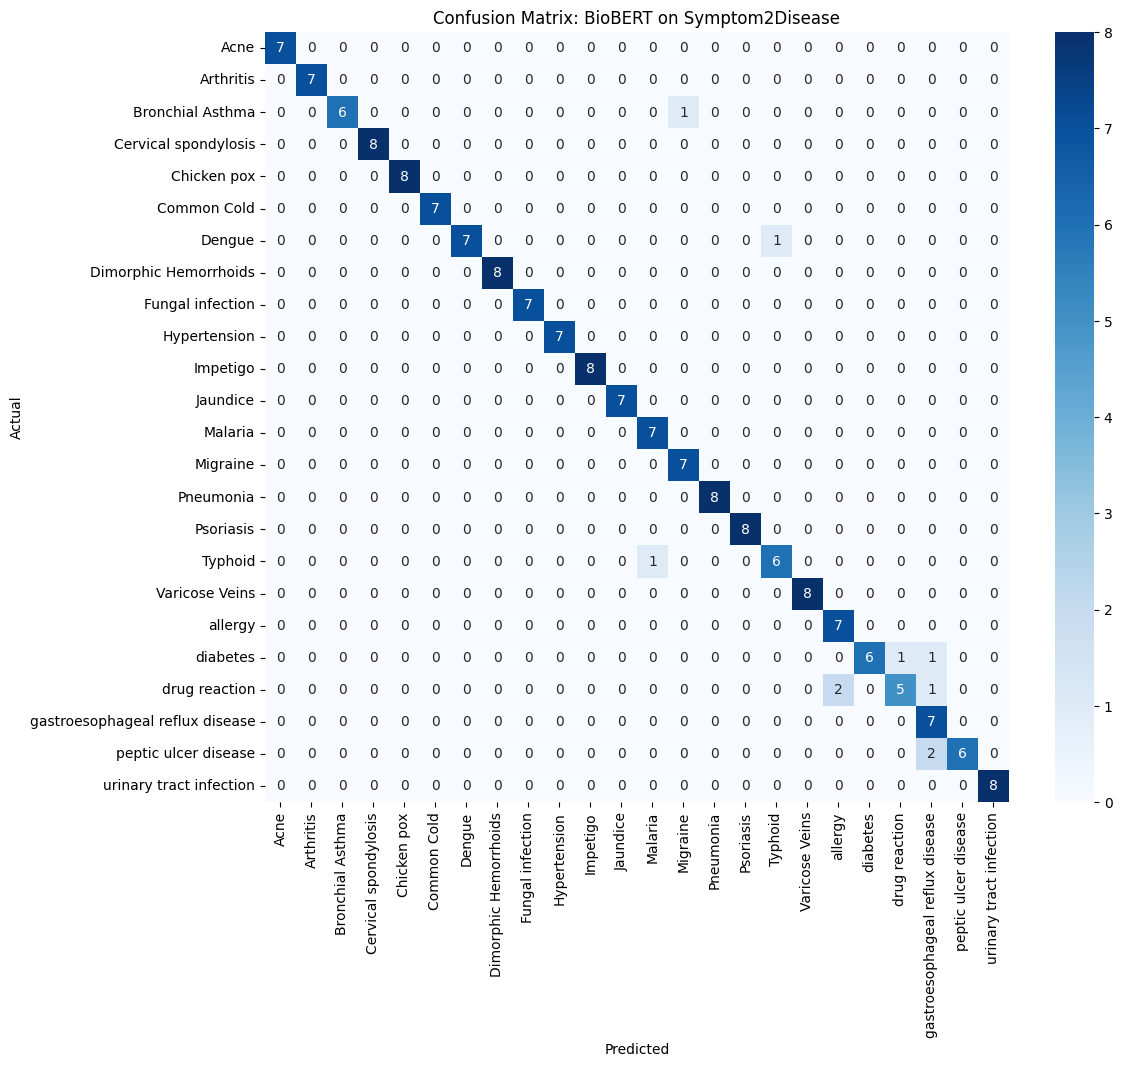

                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00         7
                      Arthritis       1.00      1.00      1.00         7
               Bronchial Asthma       1.00      0.86      0.92         7
           Cervical spondylosis       1.00      1.00      1.00         8
                    Chicken pox       1.00      1.00      1.00         8
                    Common Cold       1.00      1.00      1.00         7
                         Dengue       1.00      0.88      0.93         8
          Dimorphic Hemorrhoids       1.00      1.00      1.00         8
               Fungal infection       1.00      1.00      1.00         7
                   Hypertension       1.00      1.00      1.00         7
                       Impetigo       1.00      1.00      1.00         8
                       Jaundice       1.00      1.00      1.00         7
                        Malaria       0.88      1.

In [7]:
# Evaluation & Visualization
# Evaluate
eval_result = trainer.evaluate()
print(f"Final Test Metrics: {eval_result}")

# Predict
predictions = trainer.predict(test_dataset)
y_preds = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Plot
plt.figure(figsize=(12, 10)) # Adjusted size for better visibility
cm = confusion_matrix(y_true, y_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix: BioBERT on Symptom2Disease')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=90)
plt.show()

print(classification_report(y_true, y_preds, target_names=le.classes_))

In [8]:
# Save & Export
output_path = "biobert_disease_model"
model.save_pretrained(output_path)
tokenizer.save_pretrained(output_path)
joblib.dump(le, 'label_encoder.pkl')
print("Model and Encoder saved successfully.")

Model and Encoder saved successfully.


In [9]:
import shutil
import os

# Zip the model folder
shutil.make_archive('biobert_disease_model', 'zip', 'biobert_disease_model')

print("✅ Zipping complete!")
print("Look for 'biobert_disease_model.zip' and 'label_encoder.pkl' in the Output section on the right sidebar.")
print("Download these two files to use the model locally.")

✅ Zipping complete!
Look for 'biobert_disease_model.zip' and 'label_encoder.pkl' in the Output section on the right sidebar.
Download these two files to use the model locally.


In [10]:
from IPython.display import FileLink

# Create clickable links
print("Click these links to download:")
display(FileLink('biobert_disease_model.zip'))
display(FileLink('label_encoder.pkl'))

Click these links to download:


/kaggle/working/biobert_disease_model.zip

/kaggle/working/label_encoder.pkl